In [ ]:
import spacy
from spacy.tokens import Doc
from spacy.vocab import Vocab
import numpy as np
from scipy import spatial
import pandas as pd
import array
from sklearn import metrics
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
import torch.onnx
import onnx

In [ ]:
!pip install onnx

     |████████████████████████████████| 12.8 MB 11.8 MB/s 


In [ ]:
!python -m spacy download en_core_web_md

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
     |████████████████████████████████| 96.4 MB 1.7 MB/s 
ERROR: Operation cancelled by user
^C


In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
type(nlp)

spacy.lang.en.English

In [ ]:
df = pd.read_csv("train.csv", engine='python', error_bad_lines=False, index_col='id')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
data = df[['question1', 'question2']]

In [ ]:
data_list = list(zip(list(data['question1']), list(data['question2'])))

In [ ]:
data_list[0]

('What is the step by step guide to invest in share market in india?',
 'What is the step by step guide to invest in share market?')

In [ ]:
nlp(data_list[0][0]).tensor[:5]

array([[-2.85502553e-01, -1.04933894e+00, -1.83714175e+00,
        -1.38754904e-01,  2.21111536e-01,  8.21512699e-01,
         3.84804320e+00,  1.57037091e+00,  1.40238762e+00,
        -1.51353669e+00, -1.85361576e+00, -1.15423346e+00,
        -2.25412345e+00,  4.45111418e+00,  2.78489137e+00,
         6.87332153e-02, -1.41078544e+00, -4.17306376e+00,
        -2.23620820e+00,  4.89340115e+00,  1.78866506e-01,
        -4.47662979e-01,  2.89564228e+00, -2.07077599e+00,
         3.76245403e+00,  4.56226349e-01, -2.53331780e+00,
         4.49030459e-01, -1.77216172e+00,  1.70961380e+00,
        -6.01698351e+00,  1.17936909e+00, -1.40537155e+00,
        -2.93449712e+00,  1.24626708e+00, -1.67899704e+00,
         2.57465506e+00,  7.26307154e-01, -1.65509117e+00,
        -1.17399085e+00,  2.05376506e-01, -2.72255468e+00,
         1.80539656e+00, -2.25418001e-01, -3.74671793e+00,
        -6.32416844e-01,  7.33165979e-01, -1.11582708e+00,
         1.29762232e+00, -7.99497366e-02, -4.15477753e+0

## First approach 
Make embeddings for each word in sentence, then calculate mean value for sentence. Finally calculate cosine distance between two vectors.

In [ ]:
# delete stop words, lowercase and tokenize
def tokenize(sentence: str, nlp):
  stop_words = nlp.Defaults.stop_words
  tokens = sentence.split()
  sentence_without_sw = ' '.join([token.lower() for token in tokens if token not in stop_words])
  tokens_without_sw = nlp(sentence_without_sw)
  return tokens_without_sw

In [ ]:
sentence = 'My name is definetly Vova'
tokenize(sentence, nlp)

my definetly vova

In [ ]:
def cosine_similarity(sentence1: str, sentence2: str, nlp) -> int:
  embedding1 = tokenize(sentence1, nlp).tensor.mean(axis=0)
  embedding2 = tokenize(sentence2, nlp).tensor.mean(axis=0)
  return spatial.distance.cosine(embedding1, embedding2)

In [ ]:
def predict(data_list, nlp):
  result = []
  for tup in data_list[:10000]:
    result.append(cosine_similarity(tup[0], tup[1], nlp))
  result = np.array(result)
  result /= max(result)

  return (result > 0.5).astype(int)

In [ ]:
predicted_list = predict(data_list, nlp)

In [ ]:
labels = np.array(df['is_duplicate'][:10000])

In [ ]:
metrics.accuracy_score(predicted_list, labels)

0.5445

As we can see, it is not good approach for this task. Accuracy 0.54 is too small.

Now use spacy method

In [ ]:
sentence = 'My name is definetly Vova'
sentence2 = 'My name is Vova'
toks1 = nlp(sentence)
toks2 = nlp(sentence2)
toks1.similarity(toks2)

0.9631748208608146

In [ ]:
def predict_spacy(data_list, nlp):
  result = []
  for tup in data_list[:10000]:
    result.append(nlp(tup[0]).similarity(nlp(tup[1])))
  result = np.array(result)
  return (result < 0.5).astype(int)

In [ ]:
predicted_list_spacy = predict_spacy(data_list, nlp)

In [ ]:
metrics.accuracy_score(predicted_list_spacy, labels)

0.6274

Results with spaCy approach a bit better 

## Second approach: LSTM
1. Train our own model for encoding
2. Use pre-trained encoder

Own model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
NUM_EPOCH = 80
NUM_LAYERS = 3
NUM_CLASSES = 6

BATCH_SIZE = 256
#INPUT_SIZE = 96
INPUT_SIZE = 300
HIDDEN_SIZE = 128
SEQUENCE_LEN = 25

LEARNING_RATE = 0.001

In [ ]:
# create embeddings with spaCy
def create_embeddings(data, nlp, column_number, number_of_examples):
  embeddings_list = []
  idx = 0
  for sentence in list(data.iloc[:, column_number])[:number_of_examples]:
    if not isinstance(sentence, str):
      work_sentence = str(sentence)[:SEQUENCE_LEN]
    else:
      work_sentence = sentence[:SEQUENCE_LEN]
    if idx != 0 and idx % 2000 == 0:
      print(idx)
    #try:
    spacy_embedded_sentence = nlp(work_sentence)
    #except Exception:
    #  print(Exception)
    #  continue
    tensor_width = spacy_embedded_sentence.tensor.shape[0]
    #if tensor_width < SEQUENCE_LEN:
    embedded_sentence = torch.zeros(SEQUENCE_LEN, INPUT_SIZE)
    embedded_sentence[:tensor_width, :] = torch.from_numpy(spacy_embedded_sentence.tensor)
    # else:
    #   embedded_sentence = torch.zeros(SEQUENCE_LEN, INPUT_SIZE)
    #   embedded_sentence = torch.from_numpy(spacy_embedded_sentence.tensor[:SEQUENCE_LEN, :])
    embeddings_list.append(torch.unsqueeze(embedded_sentence, 0))
    idx += 1
  return torch.cat(embeddings_list, dim=0)

In [ ]:
model_w2v = api.load("word2vec-google-news-300") 

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#create embeddings with gensim
def create_embeddings_gensim(data, column_number, number_of_examples):
  embedded_sentences = []
  for i, sentence in enumerate(list(data.iloc[:, column_number])[:number_of_examples]):
    if i % 2000 == 0:
      print(i)
    temp_sentence = []
    if not isinstance(sentence, str):
      temp_sentence = str(sentence)[:SEQUENCE_LEN]
      if len(temp_sentence) < SEQUENCE_LEN:
        temp_sentence += ' ' * (SEQUENCE_LEN - len(temp_sentence))
    else:
      temp_sentence = sentence[:SEQUENCE_LEN]
      if len(temp_sentence) < SEQUENCE_LEN:
        temp_sentence += ' ' * (SEQUENCE_LEN - len(temp_sentence))
    embedded_sentence = []
    for word in temp_sentence:
      try:
        embedding = model_w2v.get_vector(word)
      except:
        embedding = np.zeros(300)
      embedded_sentence.append(torch.unsqueeze(torch.tensor(embedding, dtype=torch.float), 0))
    embedded_sentences.append(torch.unsqueeze(torch.cat(embedded_sentence, dim=0), 0))
  return torch.cat(embedded_sentences, dim=0)

In [ ]:
#here is bidirectional LSTM
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes) -> None:
      super(LSTM, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.dropout = 0.3
      self.LSTM = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout = self.dropout)
      self.fc_1 = nn.Linear(hidden_size * 2, 128)
      self.fc_2 = nn.Linear(128, 128)
      self.fc = nn.Linear(128, num_classes)
      # x needs to be: (batch_size, seq, input_size)
  
  def forward(self, x):
    #init hidden and cell states for lstm
    #(num_layers, batch_size, hidden_size)
    # multiply x2 because here is BIDIRECTIONAL LSTM
    h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
    c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 

    x = x.to(device)
    out, _ = self.LSTM(x, (h0, c0)) 
    #out -> (batch_size, seq_length, hidden_size)
    #Decode the hidden state of the last time step
    out = out[:, -1, :]
    out = self.fc_1(out)
    out = self.fc_2(out)
    out = self.fc(out)
    # out: (n, num_classes)
    return out

  def backward(self, out, labels, criterion, optimizer):
    optimizer.zero_grad()
    labels = labels.to(device)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
def train_model(model, num_epochs, data_loader, criterion, optimizer):
  total_loss = 0
  loss_list = []
  total_steps = num_epochs * len(data_loader)
  for epoch in range(num_epochs):
    for i, (x, labels) in enumerate(data_loader):
      out = model.forward(x)
      loss = model.backward(out, labels, criterion, optimizer)
      total_loss += loss.item()
      loss_list.append(loss.item())
      if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{epoch}/{total_steps}], Loss: {loss.item():.4f}')
  return loss_list, total_loss

In [ ]:
#prepare train dataset
data_encoder = pd.read_csv('train_encoder.csv', index_col='id')
data_encoder.dropna()

,comment_text,toxicity
id,,
0,fuck you you self righteous creep,3
1,stop stop the goddam vandalism or there ll be...,2
2,i agree rt does have a few shortcomings but i...,0
3,if you would like verfiability here is the lin...,0
4,do you think there s consensus for me to be on...,0
...,...,...
34642,huy i am kyle robbins i think albert pujols is...,4
34643,unlike the ancient greeks the idiot who bloc...,4
34644,no it isn t so if you wish to delete my accou...,1


In [ ]:
#features = create_embeddings(data_encoder, nlp, 0, 25000)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [ ]:
features = create_embeddings_gensim(data_encoder, 0, 25000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [ ]:
features[0].shape

torch.Size([25, 300])

In [ ]:
len(model_w2v.get_vector('albert'))

300

In [ ]:
labels = torch.tensor(list(data_encoder['toxicity']), dtype=torch.long)
train_tensor_dataset = TensorDataset(features, labels[:25000])
train_dataloader = torch.utils.data.DataLoader(dataset=train_tensor_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

In [ ]:
#train 
model = LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [ ]:
loss_list, _ = train_model(model, NUM_EPOCH, train_dataloader, criterion, optimizer)

Epoch [1/80], Step [0/7840], Loss: 1.4750
Epoch [1/80], Step [0/7840], Loss: 1.4892
Epoch [1/80], Step [0/7840], Loss: 1.4505
Epoch [1/80], Step [0/7840], Loss: 1.4005
Epoch [1/80], Step [0/7840], Loss: 1.4131
Epoch [1/80], Step [0/7840], Loss: 1.3178
Epoch [1/80], Step [0/7840], Loss: 1.3785
Epoch [1/80], Step [0/7840], Loss: 1.3571
Epoch [1/80], Step [0/7840], Loss: 1.3542
Epoch [2/80], Step [1/7840], Loss: 1.2900
Epoch [2/80], Step [1/7840], Loss: 1.3703
Epoch [2/80], Step [1/7840], Loss: 1.2739
Epoch [2/80], Step [1/7840], Loss: 1.2951
Epoch [2/80], Step [1/7840], Loss: 1.3515
Epoch [2/80], Step [1/7840], Loss: 1.3207
Epoch [2/80], Step [1/7840], Loss: 1.3887
Epoch [2/80], Step [1/7840], Loss: 1.2386
Epoch [2/80], Step [1/7840], Loss: 1.2702
Epoch [3/80], Step [2/7840], Loss: 1.2757
Epoch [3/80], Step [2/7840], Loss: 1.3516
Epoch [3/80], Step [2/7840], Loss: 1.2166
Epoch [3/80], Step [2/7840], Loss: 1.2058
Epoch [3/80], Step [2/7840], Loss: 1.2979
Epoch [3/80], Step [2/7840], Loss:

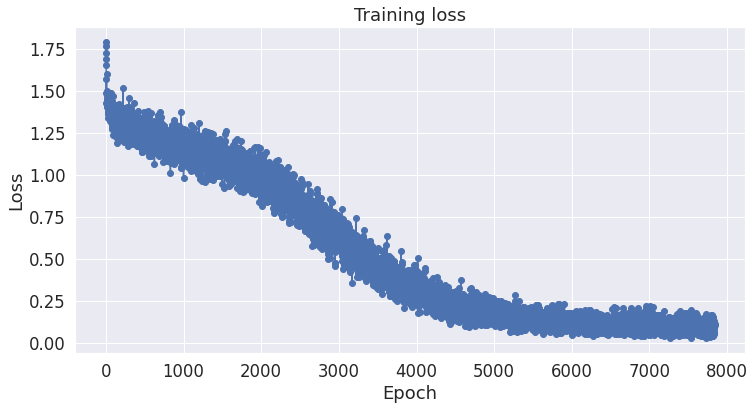

In [ ]:
#Use plot styling from seaborn.
sns.set(style='darkgrid')

#Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

#Plot the learning curve.
plt.plot(loss_list, 'b-o')

#Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
data_encoder_test = data_encoder.iloc[25000:34000, :]

In [ ]:
features_test = create_embeddings_gensim(data_encoder_test, 0, 9000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900


In [ ]:
labels_test = torch.tensor(list(data_encoder_test['toxicity']), dtype=torch.long)
test_tensor_dataset = TensorDataset(features_test, labels_test)
test_dataloader = torch.utils.data.DataLoader(dataset=test_tensor_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False)

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    predicted_list = []
    for x, labels in test_dataloader:
        x = x.to(device)
        labels = labels.to(device)
        outputs = model(x)
        #max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.extend(predicted.tolist())
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    print(metrics.accuracy_score(predicted_list, labels_test[:9000].tolist()))

0.473


In [ ]:
#save model as onnx
torch.save(model.state_dict(), 'model_encoder.pth')
dummy_input = Variable(torch.randn(1, 25, 300)).cuda()
torch.onnx.export(model, dummy_input, "model_encoder.onnx")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2123: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


In [ ]:
#this code extract encoded vector from n-th layer of nn
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_encoded_sentences(dataloader, model):
  model.fc_2.register_forward_hook(get_activation('fc_2'))
  vectors = []
  #sentence here is vector of embeddings
  for i, (sentence_batch, label) in enumerate(dataloader):
    for sentence in sentence_batch:
      #vectors.append(tensor) 
      output = model(torch.unsqueeze(sentence, 0))
      vectors.append(torch.unsqueeze(activation['fc_2'], 0))
  return torch.cat(vectors, dim=0)

In [ ]:
encoded_vectors1 = get_encoded_sentences(test_dataloader, model)

In [ ]:
len(encoded_vectors1)

9000

In [ ]:
len(encoded_vectors1[0][0])

128

In [ ]:
embeddings_sent.shape

torch.Size([4, 25, 96])

In [ ]:
sent = "hello this sentence has more than only 15 words it is definetly has a bit more words tank you"
print(nlp(str(data.iloc[1, 0])).tensor.shape)

(15, 96)


In [ ]:
data.iloc[1, 0]

'What is the story of Kohinoor (Koh-i-Noor) Diamond?'

In [ ]:
tensor = torch.zeros(5,10)
tensor

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
tensor[:, :5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
train_dataset1 = TensorDataset(torch.tensor(data['question1']))

In [ ]:
torch.tensor(list(data['question1']))

In [ ]:
data.iloc[:, 0]

id
0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
128206                            Do women enjoy anal play?
128207               Why are people so afraid of socialism?
128208    Need career related advice. I am confused as t...
128209              Why does everyone hate Hillary Clinton?
128210    Why are temperature and average kinetic energy...
Name: question1, Length: 128211, dtype: object